In [1]:
from tqdm import tqdm
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from blackjackenv_extended import BlackjackEnv
from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

using cpu


In [2]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}


def play_game(env, episodes, agent, collect_data=False, print_rewards=True):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    if print_rewards:
        #print("Rewards: ", rewards)
        print("Average Reward: ", average_reward)
        print("Variance: ", variance)
    
    return rewards

In [9]:
def plot_reward(data, title, filename, labels):
    data = np.array(data)
    np.savetxt(f'../data/{filename}.csv', data.reshape(data.shape[0], -1), delimiter=',')

    _, ax = plt.subplots()

    rolling_length = 1000

    rolling_mean = np.zeros((len(data), len(data[0]) - (rolling_length - 1))) 
    for i in range(len(data)):
        rolling_mean[i] = (np.convolve(np.array(data[i]).flatten(), np.ones(rolling_length), mode="valid")
            / rolling_length)
        ax.plot(rolling_mean[i], label=labels[i])

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.title(title)
    plt.legend()
    plt.savefig(f"../data/{filename}.png", dpi='figure', format=None)
    plt.show()

In [4]:
env = BlackjackEnv(natural=True)

episodes = 10000
collect_data = False

## Random & Basic Agents

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4304.59it/s]


Average Reward:  -0.49845
Variance:  1.498372434743624


100%|██████████| 10000/10000 [00:02<00:00, 4584.03it/s]


Average Reward:  -0.00695
Variance:  1.291205818081614


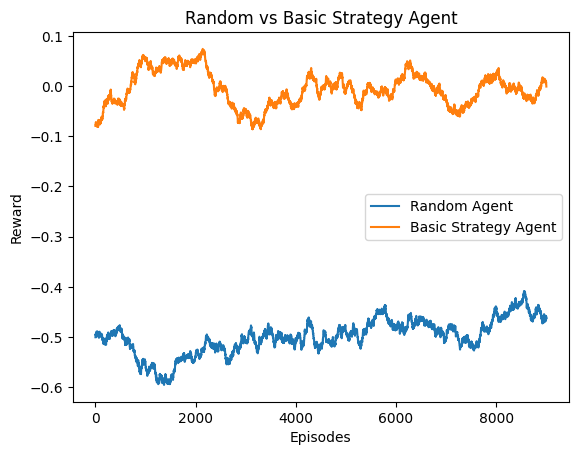

In [10]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)


agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_random, rewards_basic_strategy], "Random vs Basic Strategy Agent", "random_vs_basic_strategy", ["Random Agent", "Basic Strategy Agent"])

## FFNN & Backpropagation

In [ ]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = [9,100,100]
threshold = 3
lr = 0.01

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_FFNN, "FFNN Agent", "ffnn_agent")

100%|██████████| 3000/3000 [00:01<00:00, 2601.29it/s]


Average Reward:  -0.0028333333333333335
Variance:  1.2835031399355321


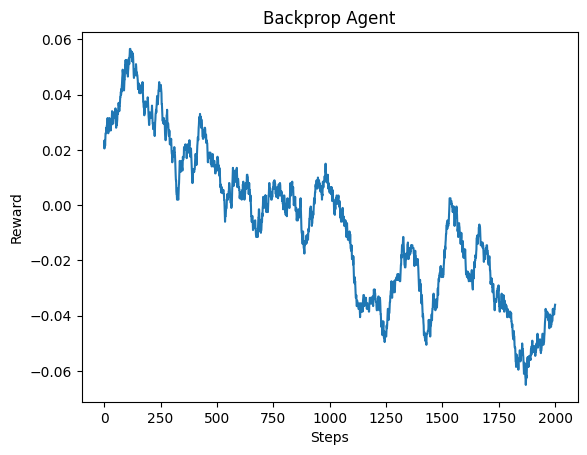

In [7]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_FFNN, "Backprop Agent", "backprop_agent")

## DQFFNN

100%|██████████| 5/5 [00:00<00:00, 92.54it/s]


Average Reward:  -1.0
Variance:  0.5


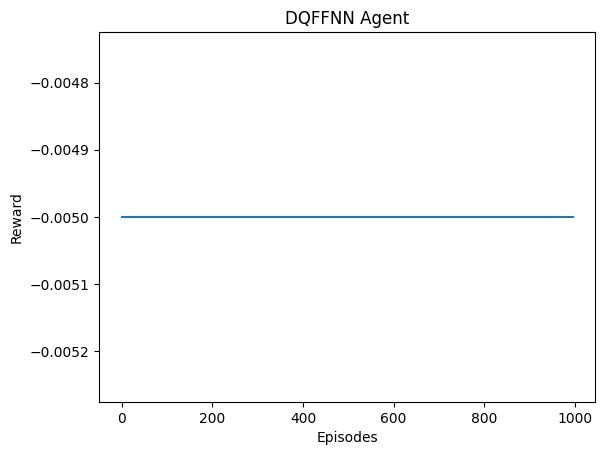

In [9]:
# DQFFNN hyperparameters
layers = [9,200,200,200]
threshold = 6
lr = 0.01

epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

agent = DQFFNNAgentBJ(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size,
    filename="dqffnn_agent"
)

#agent.model.save_model(path='../models/DQFFNN_model.pth')
rewards_DQFFNN = play_game(env, episodes, agent, collect_data)
plot_reward(rewards_DQFFNN, "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")

### Cartpole

In [10]:
layers = [6,1000,1000,1000,1000]
threshold = 0.5
lr = 0.001

episodes = 80000
epsilon = 1.0
epsilon_decay = epsilon / (episodes)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

env = gym.make("CartPole-v1")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

agent = DQFFNNAgent(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size
)

agent.model.save_model(path='../models/Cartpole_DQFFNN_model.pth')
play_game(env, episodes, agent, False, False)
rewards = np.array(env.return_queue).flatten()
average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

#print("Rewards: ", rewards)
print("Average Reward: ", average_reward)
print("Variance: ", variance)
plot_reward(rewards, "Cartpole", f"Cartpole_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 7/10000 [00:04<1:49:58,  1.51it/s]


KeyboardInterrupt: 

: 

### Mountain Car

100%|██████████| 10/10 [03:06<00:00, 18.62s/it]


Average Reward:  -200.0
Variance:  0.0


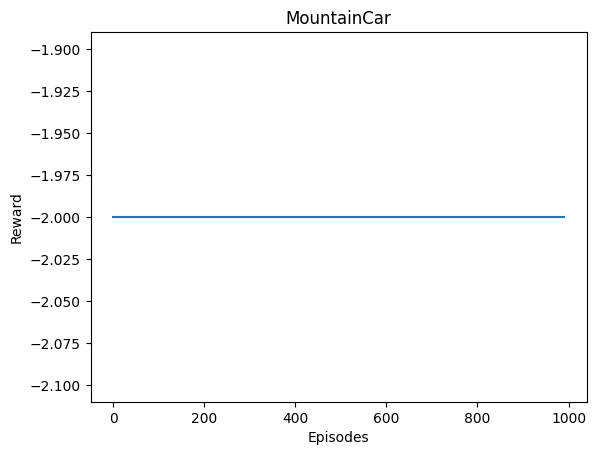

In [7]:
layers = [5,1000,1000,1000,1000]
threshold = 0.4
lr = 0.0001

episodes = 10
epsilon = 1.0
epsilon_decay = epsilon / (episodes)
discount_factor = 0.99
batch_size = 5
update_td_target = 100
buffer_size = 100000

env = gym.make("MountainCar-v0", render_mode="human")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

agent = DQFFNNAgent(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size
)

agent.model.save_model(path='../models/MountainCar_DQFFNN_model.pth')
play_game(env, episodes, agent, False, False)
rewards = np.array(env.return_queue).flatten()
average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

#print("Rewards: ", rewards)
print("Average Reward: ", average_reward)
print("Variance: ", variance)
plot_reward(rewards, "MountainCar", f"MountainCar_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")